# FastMap Tutorial

## Introduction

In this tutorial, we will introduce [the FastMap algorithm](http://repository.cmu.edu/cgi/viewcontent.cgi?article=1577&context=compsci) for mapping objects with known pairwise distances into $k$-dimensional spaces. We will introduce the basic working principle of the algorithm and illustrate 3 applications of it. In the first application, we will show the preservation of dissimilarities after FastMap by mapping words with Levenshtein distances. Then, we will show the application of FastMap in dimensionality reduction and cluster visualization through the [WINE](http://archive.ics.uci.edu/ml/datasets/Wine) data set. Finally, we will use a [Wikipedia](http://en.wikipedia.org) corpus to illustrate the application of FastMap in natural language processing.


### Table of Contents

- [Introduction](#Introduction)

The tutorial consists of two main parts. The first part introduces the FastMap algorithm.
- [FastMap: the Algorithm](#FastMap:-the-Algorithm)
   - [Problem Statement](#Problem-Statement)
   - [General Idea](#General-Idea)
   - [Pivot Choosing](#Pivot-Choosing)
   - [The Algorithm](#FastMap:-the-Algorithm)

In the second part, we will illustrate 3 applications of the FastMap algorithm.
- [Mapping with Levenshtein Distance](#Mapping-with-Levenshtein-Distance)
- [Wine Cultivars: Dimensionality Reduction](#Wine-Cultivars:-Dimensionality-Reduction)
- [Wikipedia Articles Clustering](#Wikipedia-Articles-Clustering)

Other parts include the following.
- [Conclusions and Further Readings](#Conclusions-and-Further-Readings)
- [References](#References)

## FastMap: the Algorithm

[FastMap](http://repository.cmu.edu/cgi/viewcontent.cgi?article=1577&context=compsci) is a fast algorithm proposed in 1995 by Faloutsos and Lin from University of Maryland, College Park to map objects with known pairwise distances to a $k$-dimensional space. In this part, we will introduce the basic working principle of this algorithm.


### Problem Statement

In some cases, data scientists can only have access to <cite>the similarity/distance of two objects</cite> without a well-defined <cite>feature extraction function</cite> [1]. With only the distances between the objects, we can neither perform much useful data analysis and retreival nor visualize the data in a 2d or 3d space. With this in mind, it is important to develop a fast algorithm to map such data with only pairwise distances known to a $k$-dimensional space, where we can perform data analysis and visualization.

A well-defined problem statement for FastMap is <cite>to find $N$ points in $k$-d space, whose Euclidean distances will match the distances of a given $N\times N$ distance matrix</cite> [1].


### General Idea

The basic idea of FastMap is to carefully select a line and project all the objects onto it for each dimensions. The best projection (preserves the dissimilarities the best) is given when a line $O_aO_b$ through 2 pivot objects $O_a$ and $O_b$ with the farthest distance apart is chosen.

Suppose we have found such line $O_aO_b$, the way to project an object $O_i$ onto the line is through the [Law of Cosines].

$$d_{b,i}^2=d_{a,i}^2+d_{a,b}^2-2x_id_{a,b}\qquad\Rightarrow\qquad x_i=\frac{d_{a,i}^2+d_{a,b}^2-d_{b,i}^2}{2d_{a,b}}.$$

This is illustrated by the following figure [1].

![Law of Cosines](cosine_law.png)

This gives us the mapping of an object to 1 dimension $x_i$. To map to other dimensions, we need to find the projection of the pairwise distances to the hyper-plane perpendicular to the line $O_aO_b$. Let us consider the following figure [1].

![Hyper Plane](hyper_plane.png)

From the figure, it is clear that the new distance between $O_i$ and $O_j$ is given by

$$d_{i,j}^{'2}=d_{i,j}^2-(x_i-x_j)^2,\qquad\forall i,j\in[N].$$

Then, by using the new pairwise distances given by $d'$, we can choose a new pair of pivot objects and do a mapping to a second dimension. By performing this process $k$ times recursively, we can finally project the objects into a $k$-dimensional space.


### Pivot Choosing

To choose the objects with the farthest distance apart as pivots would require inspection of each $O(N^2)$ pairwise distances between objects. To do this in each recursion renders the process rather slow.

A randomized solution to this problem proposed is to first randomly choose a point and find the point $O_a$ farthest apart from it, and then find the point $O_b$ farthest apart from $O_a$. The resulting pivots $O_a$ and $O_b$ are not necessarily the best pivots (those with the farthest distance apart), but works quit well for the FastMap algorithm. Since this process take only $O(N)$ time, it is much better than always choosing the best pair of pivots.


In [5]:
import numpy as np

def choose_pivot(dist, N):
    
    # 1) Choose arbitrarily an object, and declare it to be the second pivot object Ob
    Ob = np.random.randint(N)
    
    # 2) set Oa = (the object that is farthest apart from Ob) (according to the distance function dist)
    maximum = -1
    for i in range(N):
        d = dist(Ob, i)
        if d > maximum:
            maximum = d
            Oa = i
    
    # 3) set Ob = (the object that is farthest apart from Oa)
    for i in range(N):
        d = dist(Ob, i)
        if d > maximum:
            maximum = d
            Ob = i

    # 4) report the objects Oa and Ob as the desired pair of objects
    if Oa < Ob:
        return Oa, Ob
    else:
        return Ob, Oa


### The Algorithm

The algorithm of FastMap then follows directly from the general idea and the pivot choosing heuristic introduced above. We give an implementation of the algorithm as follows.


In [6]:
import math

class dist_:
    def __init__(self, D):
        self.col = 0
        self.X = None
        self.D = D
        
    def update(self, X):
        self.X = X
        self.col += 1
        
    def dist(self, i, j):
        dsqr = self.D[i][j] ** 2
        for c in range(self.col):
            dsqr -= (self.X[i][c] - self.X[j][c]) ** 2
        
        if dsqr > 0:
            return math.sqrt(dsqr)
        else:
            return 0

def Mapping(k, D, N, col, X, PA):
    
    if col >= k:
        return X, PA

    # choose pivot objects
    Oa, Ob = choose_pivot(D.dist, N)
    
    # record the ids of the pivot objects
    PA[0][col] = Oa
    PA[1][col] = Ob

    if(D.dist(Oa, Ob) == 0):
        # because all inter-object distances are zeros
        return X, PA

    # project the objects on the line (Oa, Ob)
    for i in range(N):
        X[i][col] = (D.dist(Oa, i) ** 2 + D.dist(Oa, Ob) ** 2 - D.dist(Ob, i) ** 2) / (2 * D.dist(Oa, Ob))

    # consider the projections of the objects on a hyper-plane perpendicular to the line (Oa, Ob)
    D.update(X)

    return Mapping(k, D, N, col + 1, X, PA)

def FastMap(k, D, N):
    
    # At the end of the algorithm, the i-th row will be the image of the i-th object.
    X = np.zeros((N, k))
    # stores the ids of the pivot objects - one pair per recursive call
    PA = np.zeros((2, k))
    D_ = dist_(D)
    # points to the column of the X[] array currently being updated
    col = 0
    
    return Mapping(k, D_, N, col, X, PA)


## Mapping with Levenshtein Distance

The FastMap algorithm maps objects with known pairwise distances to a $k$-dimensional space. It finds its immediate application when only the pairwise distances of objects are given. Levenshtein distance is such kind of distance that is calculated not from vectors but directly from words.

In this part, we will show how to visualize edit dissimilarities between words using FastMap with Levenshtein distance.

### Levenshtein Distance

The Levenshtein distance is a kind of edit distance between strings. It is defined as <cite>the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other</cite> [2]. It finds application in spell checkers and approximate string matching.

For further information, please refer to the [Wikipedia page](http://en.wikipedia.org/wiki/Levenshtein_distance).

### Data Set

The data of this part consists of 2 text files, `wordlist.txt` and `data.txt`. `wordlist.txt` consists of 10 arbitrary words, some of which has low Levenshtein distances. `data.txt` contains a complete list of the pairwise Levenshtein distances between the 10 words in `wordlist.txt`. The data set is rather small so that we can use it to illustrate the mapping ability of the FastMap algorithm.

We read in the data and store the pairwise distances between words in `dist` as an input to the FastMap algorithm.


In [14]:
wordlist = []

with open('wordlist.txt', 'r') as f:
    for line in f:
        wordlist.append(line.split())

N = len(wordlist)

dist = np.zeros((N, N))
with open('data.txt','r') as f:
    for line in f:
        l = line.split()
        i = int(l[0]) - 1
        j = int(l[1]) - 1
        d = float(l[2])
        dist[i][j] = d
        dist[j][i] = d


The following table shows the actual Levenshtein distances between each pair of words.

|acting|activist|compute|coward|forward|interaction|activity|odor|order|international|
:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
acting|0|7|4|6|7|7|4|6|6|10|
activist|4|0|7|7|8|9|2|8|8|11|
compute|7|7|0|5|6|10|6|6|6|12|
coward|6|7|5|0|2|10|7|4|5|12|
forward|7|8|6|2|0|10|8|5|4|11|
interaction|7|9|10|10|10|0|9|10|9|4|
activity|4|2|6|7|8|9|0|8|8|11|
odor|6|8|6|4|5|10|8|0|2|12|
order|6|8|6|5|4|9|8|2|0|11|
international|10|11|12|12|11|4|11|12|11|0|

### Mapping of Words with FastMap

We then map the words to a $k=2$ dimensional space so that we can visualize the the Levenshtein distance between words in a 2d plane.


In [15]:
k = 2
X, PA = FastMap(k, dist, N)


The following table shows the distances between each pair of words after being embedded into the 2d space by FastMap.

|acting|activist|compute|coward|forward|interaction|activity|odor|order|international|
:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|
acting|0.0|2.7|6.4|4.5|4.5|6.4|2.5|4.5|4.4|7.8|
activist|2.7|0.0|7.0|5.2|5.6|9.0|1.2|5.6|6.0|10.4|
compute|6.4|7.0|0.0|1.8|1.9|10.0|5.8|1.9|2.8|11.4|
coward|4.5|5.2|1.8|0.0|0.8|8.9|4.0|0.8|1.9|10.3|
forward|4.5|5.6|1.9|0.8|0.0|8.2|4.5|0.0|1.1|9.7|
interaction|6.4|9.0|10.0|8.9|8.2|0.0|8.9|8.2|7.3|1.5|
activity|2.5|1.2|5.8|4.0|4.5|8.9|0.0|4.5|4.9|10.3|
odor|4.5|5.6|1.9|0.8|0.0|8.2|4.5|0.0|1.1|9.7|
order|4.4|6.0|2.8|1.9|1.1|7.3|4.9|1.1|0.0|8.7|
international|7.8|10.4|11.4|10.3|9.7|1.5|10.3|9.7|8.7|0.0|

By comparing the table for the actual Levenshtein distances and that for the distances after embedded by FastMap, we find that the pairwise distances has not changed much, or at least preserved their relative magnitude, after the mapping.

### Visualization of Mapping

The preservation of dissimilarities after mapping with FastMap can be better observed if we plot the embedded word vectors in a 2d plane.


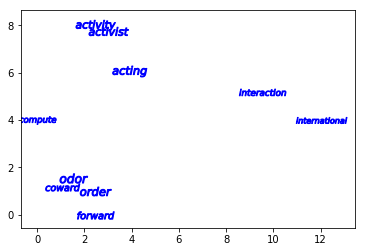

In [16]:
import matplotlib.pyplot as plt

for item in zip(X, wordlist):
    plt.scatter(item[0][0], item[0][1], c='b', marker=r'$ {} $'.format(item[1][0]), s=200 * len(item[1][0]))

plt.show()


From the figure above, we observe that the mapping of the words really reflects their edit dissimilarities. `activity` and `activist` are very close to each other with `acting` a bit farther apart. The distances between `forward` and `coward` and that between `order` and `odor` are similar. `international` and `interaction` are relatively close to each other. These features all indicate the correct edit dissimilarities between these words.


## Wine Cultivars: Dimensionality Reduction

Another important application of FastMap is in dimensionality reduction.

In this part, we will introduce how to use FastMap to reduce the dimension of a given data set so that we can visualize the data in a 2d or 3d space or perform machine learning algorithms on it more efficiently. We will also compare FastMap with one other commonly used dimensionality reduction algorithm.

### Dimensionality Reduction

In many cases of data science tasks, data is given with high dimensions. Many data sets have tens of features. Word embedding usually generates word vectors with dimensions of several hundred. Moreover, the dimensions of TFIDF (number of words encountered) and images (number of pixels) can reach several millions. In such high dimensions, 2 basic problems can occur:

1. Inefficient retrieval and processing,
2. Inability to visualize [1].

Fortunately, according to the [Johnson–Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma), if the number of data points is not large, we can embed them into a much lower dimension without much loss of dissimilarities. Such mapping of $\mathbb{R}^p\rightarrow\mathbb{R}^k$, usually with $k\ll p$, without much loss of dissimilarities is called [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction).

### Data Set

In this part, we will use the [WINE](http://archive.ics.uci.edu/ml/datasets/Wine) data set from the UCI Machine Learning Repository. The data set is used by Faloutsos and Lin themselves in their original paper of FastMap to illustrate its preservation of dissimilarities [1].

The WINE data is <cite>the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars</cite> [3]. The data set had 178 instances, each with 13 features. Since the dimension is medium, we use it to illustrate dimensionality reduction with FastMap.

We read in the data from a csv file, drop the `Cluster` column which indicate which cultivar the instance belongs to, and then perform a normalization.


In [29]:
import pandas as pd
df = pd.read_csv('wine.csv', delimiter=',', quotechar='"')
clt = df.loc[:, 'Cluster']
df.drop('Cluster', axis=1, inplace=True)
df = (df - df.mean()) / (df.max() - df.min())
N = len(df)


Since the data corresponds to wines from 3 different cultivars, there are naturally 3 clusters. Therefore, we perform a K-means clustering on it without reduction of dimensionality.


In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(df)


However, the data is 13-dimensional and is not easy to visualize. Besides comparing with the de facto clustering, we cannot know if the correctness of the clustering. Therefore, we want to perform dimensionality reduction so that we can visualize the clustering.

### Dimensionality Reduction with FastMap

Since FastMap is a map from pairwise distances to a $k$-dimensional space, to map from $p$-dimensional instances, we need to map them first to their pairwise distances. To do this, we can either provide the FastMap algorithm a distance function `dist` to calculate the pairwise distances on the fly or we can simply pre-compute all the pairwise distances. We use the latter for simplicity of illustration, but will show that the former is more efficient.

We find the pairwise distances `dist` between all instances as follows. We use Euclidean distances for `dist`.


In [31]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(df, df)


With `dist`, we can then run the FastMap algorithm with both $k=2$ and $k=3$.

In [47]:
k = 2
X2, PA2 = FastMap(k, dist, N)

k = 3
X3, PA3 = FastMap(k, dist, N)


To visualize the clustering results, we define a `show_cluster` function which works for both 2d and 3d spaces.

In [48]:
from mpl_toolkits.mplot3d import Axes3D

def show_cluster(X, clt, d):
    """
    Show 3 clusters in the 2d or 3d space as a scatter plot.

    Args:
        X:   an embedding of instances to the 2d or 3d space.
        clt: a list of the cluster number from 0 to 2.
        d:   2 or 3. The dimension of the scatter plot.
    """
    if d == 2:
        for item in zip(X, clt):
            if item[1] == 0:
                plt.scatter(item[0][0], item[0][1], c='r')
            elif item[1] == 1:
                plt.scatter(item[0][0], item[0][1], c='g')
            elif item[1] == 2:
                plt.scatter(item[0][0], item[0][1], c='b')
        
    if d == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for item in zip(X, clt):
            if item[1] == 0:
                ax.scatter(item[0][0], item[0][1], item[0][2], c='r')
            elif item[1] == 1:
                ax.scatter(item[0][0], item[0][1], item[0][2], c='g')
            elif item[1] == 2:
                ax.scatter(item[0][0], item[0][1], item[0][2], c='b')

    plt.show()


We first visualize the learned and actual clusters with instances mapped to a 2d plane.

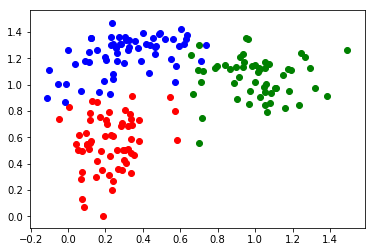

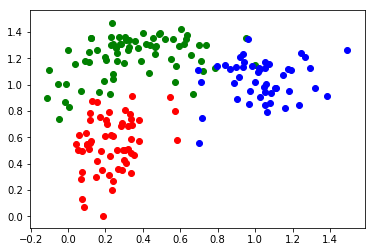

In [49]:
show_cluster(X2, kmeans.labels_, 2)
show_cluster(X2, np.array(clt) - 1, 2)


The first figure is the learned clustering, and the second is the actual clustring. We can see from the figures that the 3 clusters has already been seperated apart a little. Now, let us see a 3d mapping.


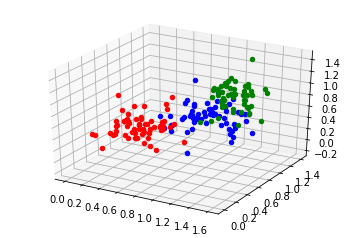

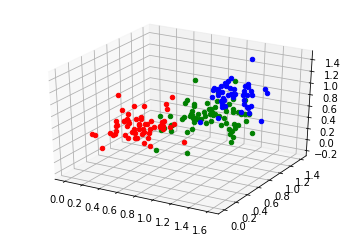

In [50]:
show_cluster(X3, kmeans.labels_, 3)
show_cluster(X3, np.array(clt) - 1, 3)


The first figure is the learned clustering, and the second is the actual clustring. if we can rotate the axis, we would find that the 3 clusters has almost been completely seperated in the 3d space.

This indicates that FastMap preserves dissimilarities between data points well when mapping them to lower dimensions.

Actually, since the dissimilarity is well-preserved, we can directly perform K-means on the reduced data set. We first map the instances to a 5d space and then perform K-means on the 5d data.


In [56]:
k = 5
X5, PA5 = FastMap(k, dist, N)

kmeans5 = KMeans(n_clusters=3, random_state=0).fit(X5)

print('Full data: {}'.format(kmeans.labels_))
print('Reduced data: {}'.format(kmeans5.labels_))
print('Actual cluster: {}'.format(np.array(clt) - 1))


Full data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 2 2 2 2 2 1 2 1 2 2 0
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Reduced data: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 1 0 0 1 0 0 0 2 1 2 1
 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Actual cluster: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1

From the clustring result, we find that the number of mis-clasified instances for with the full data is 9. For the data reduced to 5 dimensions using FastMap, the number of mis-clasified instances is 13. Most features of the chemicals that indicates the cultivars are preserved after a mapping from 13 dimensions to 5 dimensions. Furthermore, since K-means has a time complexity of $O(N^{dk+1})$, the run time of K-means is apparently reduced after the mapping.

### Comparison with PCA

[Principle Component Analysis (PCA)](http://www.datasciencecourse.org/notes/unsupervised/unsupervised.pdf) is a commonly used dimensionality reduction algorithm. With simple analysis, we can show that the time complexity of PCA is $O(p^2N+p^3)$, where $p$ is the dimension reduced from, and $n$ is the number of instances.

According to Faloutsos and Lin, the complexity of FastMap is $O(kN)$ distance computations `dist`, which follows immediately by analyzing the main function of the algorithm. If we calculate the distance on the fly, each distance computation would take $O(p+k)$, $O(p)$ to find the original Euclidean distance and $O(k)$ to preject it to the current perpendicular hyper-plane. Therefore, the total complexity of FastMap is $O(k^2N+kpN)$. However, since for most dimensionality reduction jobs, $k\ll p$, $O(k^2N+kpN)\ll O(p^2N+p^3)$, indicating that FastMap is indeed fast in dimensionality reduction. Considering that it preserves dissimilarities well, it is a comperative candidate for dimensionality reduction. The FastMap do has its disadvantage in dimensional reduction in that the pivot choosing process is highly random, making the result unstable.


## Wikipedia Articles Clustering

In this part, we will show a real application of FastMap in document visualization and clustering. We will use cosine similarities between TFIDFs of documents as a metrics of distance `dist` between documents.

### Corpus

The corpus contains the introduction part of 50 [Wikipedia](en.wikipedia.org) articles belonging to 3 categories, animal, city, and university. The corpus is rather similar to the Federalist Papers corpus in Homework 3 of the [Practical Data Science course](http://www.datasciencecourse.org/). Therefore, the following code to load and tokenize the document is borrowed [4].


In [68]:
import re

def load_wikipedia_corpus(filename):
    """ Load the wikipedia articles as a tokenized list of strings, one for each article"""
    with open(filename, "rt") as f:
        data = f.read()
    articles = data.split("WIKIPEDIA")
    
    # all start with "CONTENTS OF INTRODUCTION:"
    # all end with THE END
    locations = [(i,[-1] + [m.end()+1 for m in re.finditer(r"CONTENTS OF INTRODUCTION", p)],
                 [-1] + [m.start() for m in re.finditer(r"REFERENCE", p)]) for i,p in enumerate(articles)]
    articles_content = [articles[i][max(loc[1]):max(loc[2])] for i,loc in enumerate(locations)]

    # discard entries that are not actually an article
    articles_content = [p for p in articles_content if len(p) > 0]

    # replace all whitespace with a single space
    articles_content = [re.sub(r"\s+", " ", p).lower() for p in articles_content]

    # add spaces before all punctuation, so they are separate tokens
    punctuation = set(re.findall(r"[^\w\s]+", " ".join(articles_content))) - {"-","'"}
    for c in punctuation:
        articles_content = [p.replace(c, " "+c+" ") for p in articles_content]
    articles_content = [re.sub(r"\s+", " ", p).lower().strip() for p in articles_content]
    
    categories = [tuple(re.findall("ANIMAL|CITY|UNIVERSITY", a)) for a in articles]
    categories = [a for a in categories if len(a) > 0]
    
    titles = [re.sub(r'_', r' ', re.search(r"No\. \d+\n+(.+)", p).group(1)) for p in articles if re.search(r"No\. \d+", p)]
    
    return articles_content, categories, titles
    

We read in and tokenize the corpus from the file `wikipedia.txt`. We mark cotegories of animal, city, and university with 0, 1, and 2, respectively.

In [69]:
articles, categories, titles = load_wikipedia_corpus("wikipedia.txt")
for i in range(len(categories)):
    if len(categories[i]) == 1 and categories[i][0] == 'ANIMAL':
        categories[i] = 0
    elif len(categories[i]) == 1 and categories[i][0] == 'CITY':
        categories[i] = 1
    elif len(categories[i]) == 1 and categories[i][0] == 'UNIVERSITY':
        categories[i] = 2


### TFIDF and Cosine Similarity

We then define a function that returns the TFIDF of all the 50 Wikipedia articles.


In [59]:
import collections
import scipy.sparse as sp

def tfidf(docs):
    """
    Create TFIDF matrix.  This function creates a TFIDF matrix from the
    docs input.

    Args:
        docs: list of strings, where each string represents a space-separated
              document
    
    Returns: tuple: (tfidf, all_words)
        tfidf: sparse matrix (in any scipy sparse format) of size (# docs) x
               (# total unique words), where i,j entry is TFIDF score for 
               document i and term j
        all_words: list of strings, where the ith element indicates the word
                   that corresponds to the ith column in the TFIDF matrix
    """
    word_dict = {}
    word_freq = {}
    data = []
    row_ind = []
    col_ind = []
    w = -1
    i = 0
    
    for doc in docs:
        words = doc.split()
        
        counter = collections.Counter(words)
        
        for word, freq in counter.items():
            w = w if word in word_dict else w + 1
            word_dict[word] = word_dict[word] if word in word_dict else w
            word_freq[word] = word_freq[word] + 1 if word in word_freq else 1
            j = word_dict[word]
            data.append(freq)
            row_ind.append(i)
            col_ind.append(j)
            
        i += 1
    
    idf = np.zeros(len(word_dict))
    
    for word in word_dict:
        idf[word_dict[word]] = math.log(len(docs) / word_freq[word])
    
    k = 0
    while k < len(data):
        data[k] *= idf[col_ind[k]]
        if data[k] == 0:
            del data[k]
            del row_ind[k]
            del col_ind[k]
        else:
            k += 1
    
    tfidf = sp.csr_matrix((data, (row_ind, col_ind)))
    
    all_words = [0] * len(word_dict)
    
    for word, i in word_dict.items():
        all_words[i] = word
    
    return (tfidf, all_words)
    

Since the TFIDF for a document is a sparse vector with dimension equal to the number of unique words in the whole corpus, to directly use it as a metrics for machine learning tasks is impractical, nor can we visualize the TFIDF. The meaningful thing about TFIDFs is only the cosine similarity between them.

With the TFIDFs, we can find the pairwise cosine similarities between all 50 articles. With this as a metrics, the distance between 2 articles is then

$$\mathrm{distance}=\frac{2}{\pi}\cos^{-1}(\mathrm{cosine\ similarity}).$$


In [60]:
def distance(X):
    """
    Return a matrix of dissimilarities indicated by the cosine similarity.
    
    Args:
        X: sparse matrix of TFIDF scores or term frequencies
    
    Returns:
        M: dense numpy array of all pairwise dissimilarities.
    """
    Xd = X.todense()
    
    CS = np.zeros((len(Xd), len(Xd)))
    for doc1 in range(len(Xd)):
        for doc2 in range(len(Xd)):
            if doc1 == doc2:
                CS[doc1][doc2] = np.nan
            else:
                CS[doc1][doc2] = Xd[doc1] @ Xd[doc2].T / np.linalg.norm(Xd[doc1]) / np.linalg.norm(Xd[doc2])
            
    return 2 / math.pi * np.arccos(CS)


With these functions, we can find the pairwise distance matrix between articles. Since the distance between most articles are close to 1, we rescale it to make the minimum distance 0 and the maximum 1.

In [70]:
X_tfidf, words = tfidf(articles)
N = len(articles)
dist = distance(X_tfidf)
dist = (dist - np.nanmin(dist)) / (np.nanmax(dist) - np.nanmin(dist))
dist = np.nan_to_num(dist)


### Clustring of Articles in 3D

With a reasonable `dist` metrics in place, it is then the task of FastMap to map the articles into a $k$-dimensional space.

In this part, we first map the articles into a 3d space.

In [115]:
k = 3
X3, PA3 = FastMap(k, dist, N)


We then perform a clustering on them and visualize the result by `show_cluster`.

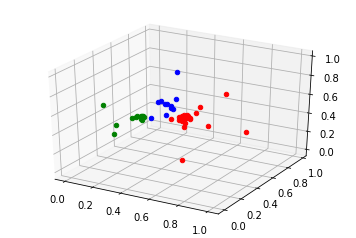

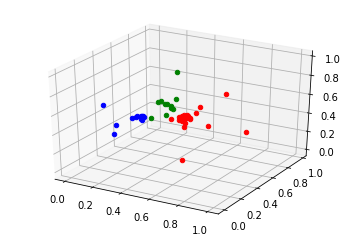

In [116]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X3)
show_cluster(X3, kmeans.labels_, 3)
show_cluster(X3, np.array(categories), 3)


The first figure shows the clustering by K-means in 3d space, red for animals, blue for cities, and green for universities. The second figures shows the actual categories of the ariticles, red for animals, green for cities, and blue for universities.

This time, FastMap is able to preserve the dissimilarity structure of the articles completely in a 3d space, since all the articles are classified correctly. By running the process multiple times, FastMap together with K-means produces low error rate clustering in 3d space more than 80% of times.

### Visualization of Articles in 2D

In this part, we map the Wikipedia articles into a 2d space and visualize them with their titles as markers.

To do this, we first define a function `show_cluster_labeled` to show the categories of the articles in the 2d space as a scatter plot with article titles as markers.


In [138]:
def show_cluster_labeled(X, clt, titles, xmin=None, xmax=None, ymin=None, ymax=None):
    """
    Show 3 clusters in the 2d space as a scatter plot with customized markers.

    Args:
        X:      an embedding of instances to the 2d or 3d space.
        clt:    a list of the cluster number from 0 to 2.
        titles: a list of customized markers.
        xmin, xmax, ymin, ymax: optional. axis range for the plot.
    """
    plt.figure(figsize = (20, 10))
    if xmin == None:
        plt.autoscale()
    else:
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

    for item in zip(X, clt, titles):
        if item[1] == 0:
            plt.scatter(item[0][0], item[0][1], c='r', marker=r'$ {} $'.format(item[2]), s=400 * len(item[2]))
        elif item[1] == 1:
            plt.scatter(item[0][0], item[0][1], c='g', marker=r'$ {} $'.format(item[2]), s=400 * len(item[2]))
        elif item[1] == 2:
            plt.scatter(item[0][0], item[0][1], c='b', marker=r'$ {} $'.format(item[2]), s=400 * len(item[2]))
    
    plt.show()


We map the articles into a 2d space via FastMap.

In [160]:
k = 2
X2, PA2 = FastMap(k, dist, N)


We then visualize the articles in the mapped 2d space with K-means clustering in 2d and actual categories.

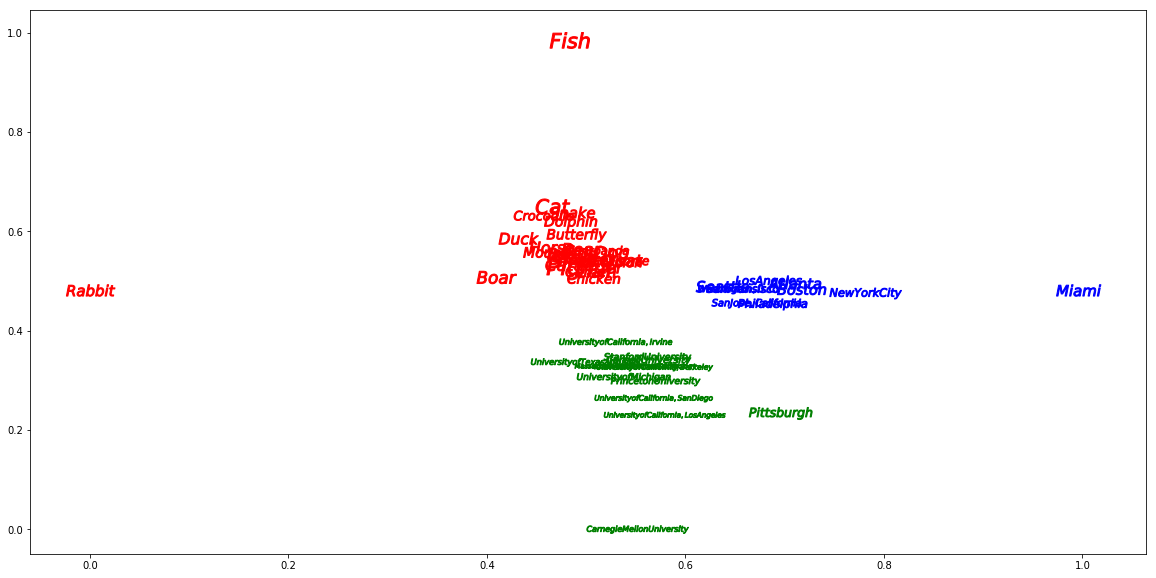

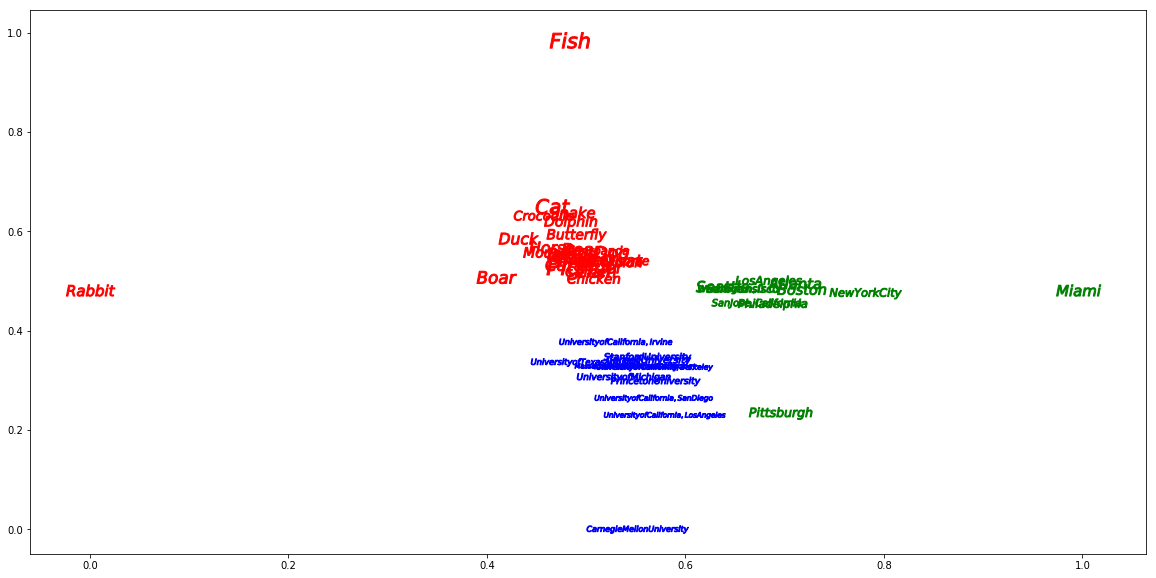

In [161]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X2)
show_cluster_labeled(X2, kmeans.labels_, titles)
show_cluster_labeled(X2, np.array(categories), titles)


The first figure is the k-means clustering in 2d, while the second is the actual categories. We can find that there is only one mis-clasified article, `Pittsburgh`. This indicates a preservation of dissimilarity structure. In fact, there are a lot of universities and educational resources in Pittsburgh, and in some dimensions, Pittsburgh is really closer to universities than to the other cities. Since FastMap maps it to 2d, it by chance amplifies this effect, resulting in Pittsburgh's being clustered as a university.

Some other interesting effects can also be observed. `Pittsburgh` has relatively low $y$-axis value compared to other cities, while `Carnegie Mellon University` has relatively low $y$-axis compared to other universities. Since CMU is in Pittsburgh, this seems to reflect an analogous relationship similar to that in word embedding.

We now further zoom into the central of the figure to observe more phenomena.


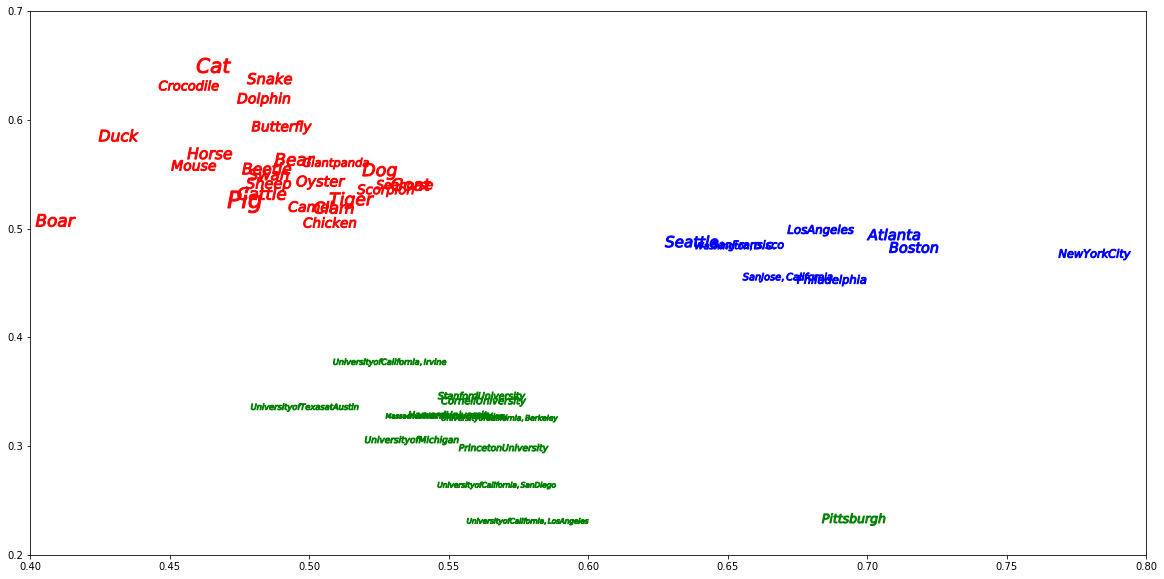

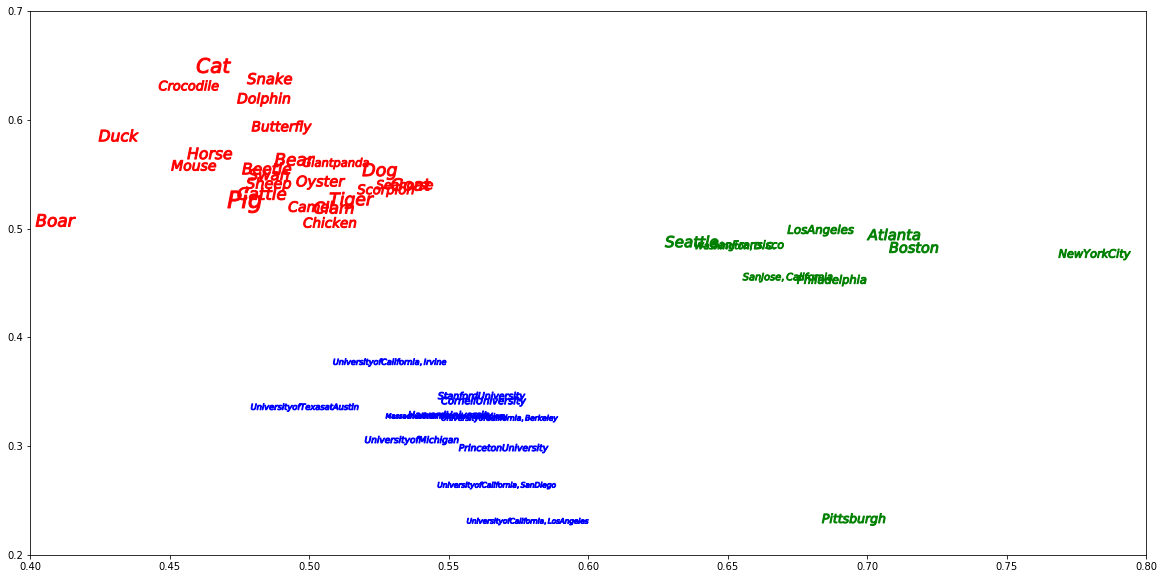

In [163]:
show_cluster_labeled(X2, kmeans.labels_, titles, 0.4, 0.8, 0.2, 0.7)
show_cluster_labeled(X2, np.array(categories), titles, 0.4, 0.8, 0.2, 0.7)

Let us focus on the cities. We can find that all the cities on the west coast of the US has lower $x$-axis value compared to those on the east coast. Other interesting effects can be observed, like working animals such as horse, sheep, cattle, and pig are close to each other.


## Conclusions and Further Readings

In this tutorial, we introduced the basic principles of [the FastMap algorithm](http://repository.cmu.edu/cgi/viewcontent.cgi?article=1577&context=compsci) proposed by Faloutsos and Lin. We then introduced its application in distance based mapping, dimensionality reduction, and natural language processing.

For more details on application of FastMap in visualizing clusters, please refer to [A Visual Method of Cluster Validation with Fastmap](https://link.springer.com/chapter/10.1007/3-540-45571-X_18).

FastMap also finds more advanced applications in the A\* shortest path finding algorithm. Cohen <cite>et. al.</cite> introduced a new A\* heuristic that utilizes FastMap that is faster and better than the commonly used Manhattan Distance Heuristic in their paper [The FastMap Algorithm for Shortest Path Computations](http://isaim2018.cs.virginia.edu/papers/ISAIM2018_Cohen_etal.pdf).

There is also an existing implementation of FastMap at http://gromgull.net/2009/08/fastmap.py.


## References

1. FastMap: A Fast Algorithm for Indexing, Data-Mining and Visualization of Traditional and Multimedia Datasets: http://repository.cmu.edu/cgi/viewcontent.cgi?article=1577&context=compsci
2. Levenshtein distance: https://en.wikipedia.org/wiki/Levenshtein_distance
3. Wine Data Set: http://archive.ics.uci.edu/ml/datasets/Wine
4. Practical Data Science Homework 3: http://www.datasciencecourse.org/hw/hw3/handout.tar.gz